In [1]:
from __future__ import absolute_import, division
import glob
import os
import re
import json
from astropy.io import fits as fits
import matplotlib.dates as mdates
import torch
import h5py
import datetime
import numpy as np
import matplotlib

import torch.nn.functional as F

#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
this_dir = os.getcwd()

import matplotlib as mpl
# try to use the precise epoch
mpl.rcParams['date.epoch']='1970-01-01T00:00:00'
try:
    mdates.set_epoch('1970-01-01T00:00:00')
except:
    pass

from tqdm import tqdm
%matplotlib inline

import matplotlib.style as mplstyle
mplstyle.use('fast')
import platform

%load_ext autotime

%load_ext autoreload
%autoreload 2


time: 187 ms (started: 2022-07-16 01:31:06 +03:00)


In [2]:
import gc
gc.collect()

def partition_avg(arr, ratio_range):
    #  average in a given ratio range to exclude extreme value
    arr_sort = np.sort(arr.ravel())
    nums = arr_sort[int(ratio_range[0]*arr_sort.shape[0]):int(ratio_range[1]*arr_sort.shape[0])]
    return np.mean(nums)

time: 266 ms (started: 2022-07-16 01:31:06 +03:00)


In [3]:
# add current path as python path
import sys
this_dir = os.getcwd()
sys.path.append(this_dir)

time: 188 ms (started: 2022-07-16 01:31:06 +03:00)


In [4]:
if platform.system()=='Windows':
    h5dir = 'D://H5/'

else:
    h5dir = './H5/'

time: 172 ms (started: 2022-07-16 01:31:06 +03:00)


In [5]:
x_points = 900 # time sample points
y_points = -1 # f samples  (-1 for not down sampling, keep origional) 
chunk_t = datetime.timedelta(minutes=15)
chop_off = False # chop every **interger** 15 minutes [00:15,00:30,00:45....]

# IMORTANT!! give absolute (or relative) paths to the next array: first of the calibrator, and then of the target source

h5_fname = 'L860566_SAP000_B000_S0_P000_bf.h5'
work_dir = this_dir
#os.getcwd()

time: 172 ms (started: 2022-07-16 01:31:07 +03:00)


In [6]:
os.chdir(work_dir) # go back home
os.chdir(h5dir)
m = re.search('B[0-9]{3}', h5_fname)
m.group(0)
beam_this = m.group(0)[1:4]
m = re.search('SAP[0-9]{3}', h5_fname)
m.group(0)
SAP = m.group(0)[3:6]

f = h5py.File( h5_fname, 'r' )
group = f['/']
        #keys = sorted(['%s'%item for item in sorted(list(group.attrs))])
        
        # obtain name of calibrator
target_obs = group.attrs['TARGETS']
calibrator_name = [x for x in target_obs if x!='Sun'][0]
        
data_shape = f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'].shape
#data_lightcurve_cal=f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'][:,600]

time: 172 ms (started: 2022-07-16 01:31:07 +03:00)


In [7]:
total_t=f['/'].attrs['TOTAL_INTEGRATION_TIME']

freq = f['/SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/COORDINATES/COORDINATE_1'].attrs['AXIS_VALUES_WORLD']/1e6

data_shape

(2746560, 6400)

time: 172 ms (started: 2022-07-16 01:31:07 +03:00)


In [8]:
t0_idx = 2500#1800000

time: 171 ms (started: 2022-07-16 01:31:07 +03:00)


In [9]:
data_test=f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'][t0_idx:t0_idx+96*80,:]
#data_test=f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'][t0_idx+96*15:t0_idx+96*20,0:500]
data_test = data_test/data_test[0,:]

time: 266 ms (started: 2022-07-16 01:31:07 +03:00)


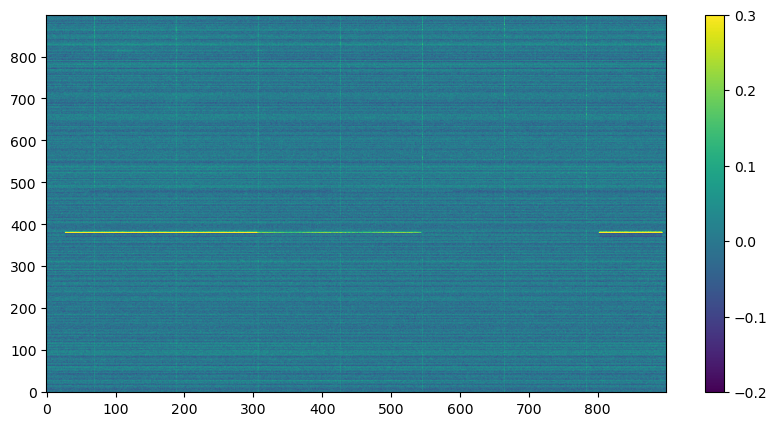

time: 813 ms (started: 2022-07-16 01:31:08 +03:00)


In [10]:
plt.figure(figsize=(10,5),dpi=100)
plt.imshow(np.log10(data_test).T[2000:2900,0:900],interpolation=None,aspect='auto',origin='lower',vmax=0.3,vmin=-0.2)
#plt.xlim(2000,3000)
#plt.ylim(5000,6000)
plt.colorbar()

In [11]:

import torch.nn.functional as F
from RFIconvFlag import *

# reload data
data_test=f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'][t0_idx:t0_idx+96*60*10,:]
#data_test=f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'][t0_idx+96*15:t0_idx+96*20,0:500]


# increase dimention of array


time: 813 ms (started: 2022-07-16 01:31:09 +03:00)


In [12]:
import sys
sys.getsizeof(data_test)/(1024**3) # in GB

1.373291127383709

time: 187 ms (started: 2022-07-16 01:31:09 +03:00)


In [13]:
freq_window=16
time_window=192

conv_down =  F.conv2d(torch.tensor(data_test[None,None,:,:]),
    torch.ones([1,1,time_window,freq_window])/freq_window/time_window,
    stride=(time_window,freq_window),padding=(0,0))

avg_spec = conv_down.squeeze()

time: 485 ms (started: 2022-07-16 01:31:10 +03:00)


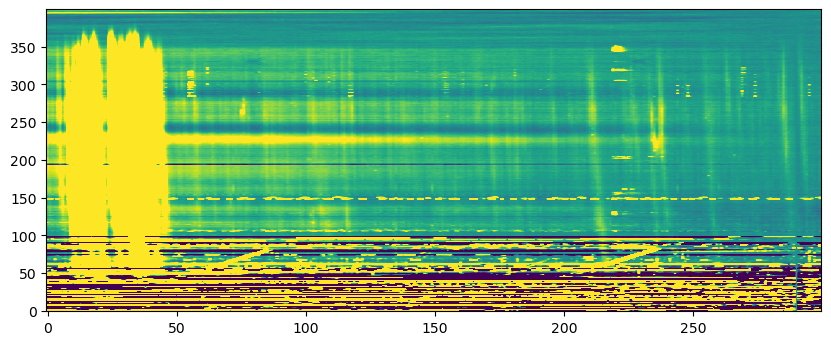

time: 391 ms (started: 2022-07-16 01:31:10 +03:00)


In [14]:

avg_spec_plot = avg_spec/avg_spec[-10,:]

plt.figure(figsize=(10,4),dpi=100)
plt.imshow(np.log10(avg_spec_plot).T,interpolation=None,aspect='auto',origin='lower',vmax=0.02,vmin=-0.02)

In [15]:
data_sampling=f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'][t0_idx:t0_idx+96*800:192,::32]

time: 3.86 s (started: 2022-07-16 01:31:11 +03:00)


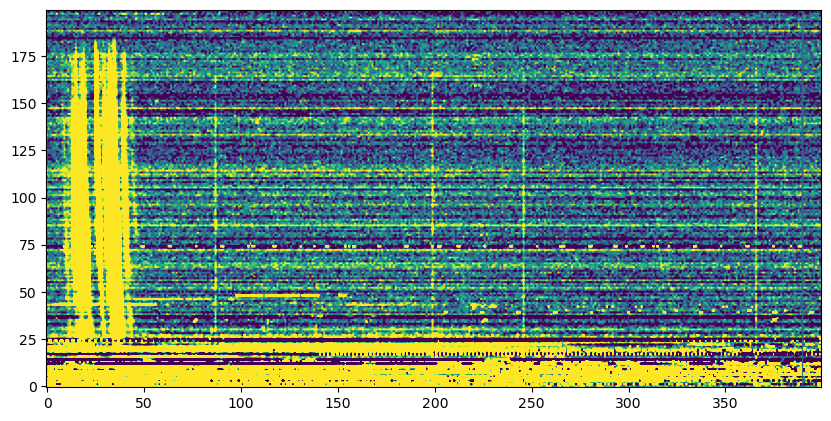

time: 375 ms (started: 2022-07-16 01:31:15 +03:00)


In [16]:

data_sampling = data_sampling/data_sampling[-10,:]

plt.figure(figsize=(10,5),dpi=100)
plt.imshow(np.log10(data_sampling).T,interpolation=None,aspect='auto',origin='lower',vmax=0.08,vmin=-0.04)

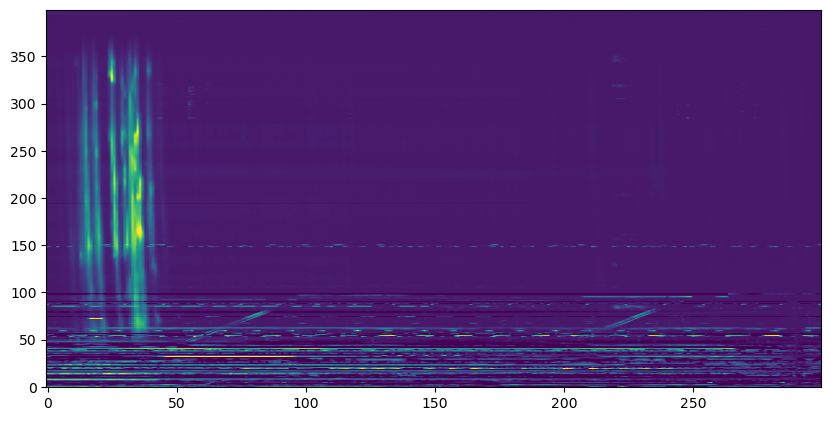

time: 344 ms (started: 2022-07-16 01:31:15 +03:00)


In [17]:

plt.figure(figsize=(10,5),dpi=100)
plt.imshow(np.log10(avg_spec_plot).T,interpolation=None,aspect='auto',origin='lower',vmax=1.4,vmin=-0.1)

In [18]:
total_t/data_shape[0]

0.01048576

time: 172 ms (started: 2022-07-16 01:31:15 +03:00)


In [97]:
t0_idx = 2500
t_duration_idx = 96*60*3
data_test=f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'][t0_idx:t0_idx+t_duration_idx,:]
#data_test=f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'][t0_idx+96*15:t0_idx+96*20,0:500]
#data_test = data_test/data_test[0,:]


print(sys.getsizeof(data_test)/(1024**3)) # in GB

0.41198741644620895
time: 484 ms (started: 2022-07-16 02:09:50 +03:00)


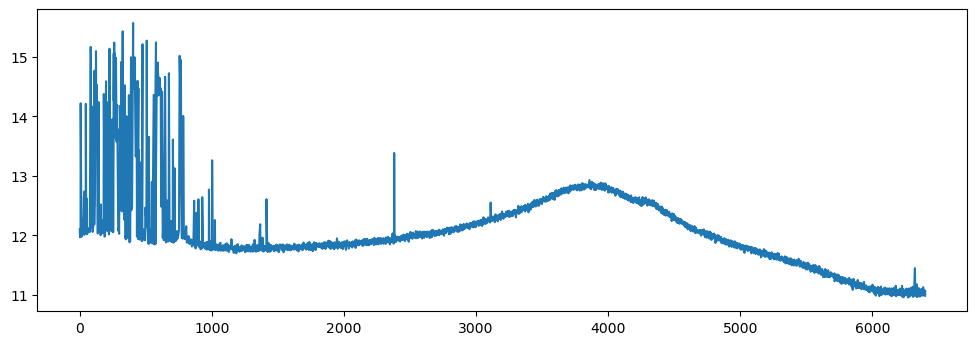

time: 281 ms (started: 2022-07-16 02:09:53 +03:00)


In [98]:
plt.figure(figsize=(12,4),dpi=100)
plt.plot(np.log10(data_test[300,:]))

In [99]:
#net = init_net(net,[1.6,1.65])
from RFIconvFlag import  RFIconv,init_RFIconv

device ='cpu'
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


if device!='cpu':
    torch.cuda.empty_cache() 

net = RFIconv(device=device)

factors = [[0.01,0.01,0.45,0.45],[1.65,1.65,0.01,0.01],[1.65,1.65,0.45,0.45]]

data_test_ma_0 =[]

for agg_factor in factors:

    net = init_RFIconv(net,aggressive_factor = agg_factor,device=device).to(device)
    with torch.no_grad():
        output = net(torch.tensor(data_test.squeeze()[None,None,:,:]).to(device)).squeeze().cpu().numpy()
    data_test_ma = np.ma.masked_where((output),data_test.squeeze())
    data_test_ma_0.append(data_test_ma)
    if device!='cpu':
        torch.cuda.empty_cache() 

time: 47.2 s (started: 2022-07-16 02:09:54 +03:00)


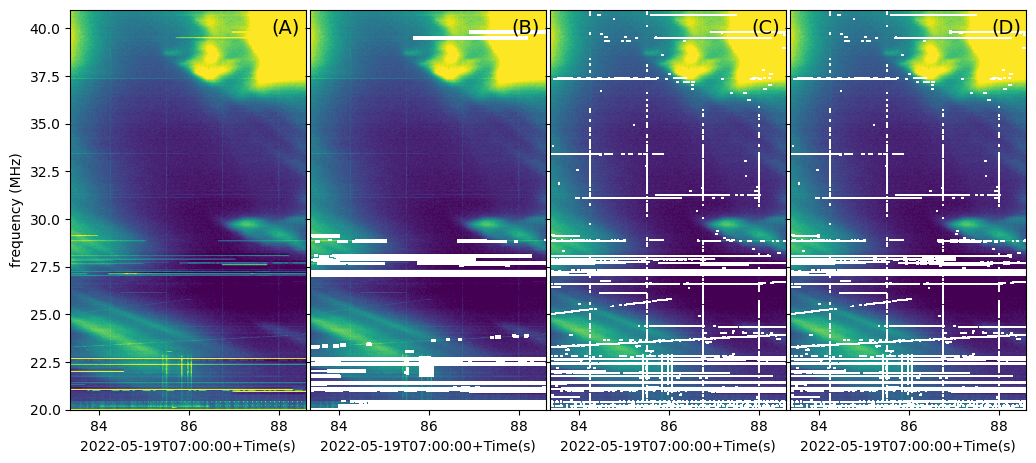

time: 1.17 s (started: 2022-07-16 02:04:58 +03:00)


In [81]:
t_idx0,t_idx1,f_idx0,f_idx1 = 5050,5850,782,3200
t_idx0,t_idx1,f_idx0,f_idx1 = 5450,5950,782,2500


fig = plt.figure(figsize=(8,5),dpi=100)
ax1 = fig.add_axes([0.1,0.1,0.3-0.005,0.8])
ax1.imshow(np.log10(data_test.squeeze()[t_idx0:t_idx1,f_idx0:f_idx1]).T,
    interpolation=None,aspect='auto',origin='lower',vmax=12.3,vmin=11.8,
    extent=[(t_idx0+t0_idx)*total_t/data_shape[0],(t_idx1+t0_idx)*total_t/data_shape[0],
    freq[f_idx0],freq[f_idx1]])
plt.setp(ax1, xlabel=f['/'].attrs['OBSERVATION_START_UTC'][0:19]+'+Time(s)', ylabel='frequency (MHz)')
# text on upper left corner
ax1.text(0.85, 0.94, '(A)', transform=ax1.transAxes, fontsize=14)

texthub = ['(B)','(C)','(D)']
for idxtmp in range(3):
    ax2 = fig.add_axes([0.4+0.3*idxtmp,0.1,0.3-0.005,0.8])
    ax2.imshow(np.log10(data_test_ma_0[idxtmp][t_idx0:t_idx1,f_idx0:f_idx1]).T,
        interpolation=None,aspect='auto',origin='lower',vmax=12.3,vmin=11.8,
        extent=[(t_idx0+t0_idx)*total_t/data_shape[0],(t_idx1+t0_idx)*total_t/data_shape[0],
        freq[f_idx0],freq[f_idx1]])
    plt.setp(ax2, xlabel=f['/'].attrs['OBSERVATION_START_UTC'][0:19]+'+Time(s)',yticklabels=[])
    
    ax2.text(0.85, 0.94, texthub[idxtmp], transform=ax2.transAxes, fontsize=14)

fig.savefig(work_dir+'/RFIconv.pdf',bbox_inches='tight')

In [100]:
time_window=64
freq_window=16

conv_down_direct =  F.conv2d(torch.tensor(data_test[None,None,:,:]),
        torch.ones([1,1,time_window,freq_window])/freq_window/time_window,
        stride=(time_window,freq_window),padding=(0,0)).squeeze().numpy()


conv_down_after_flag =  F.conv2d(torch.tensor(data_test[None,None,:,:]*(~output[None,None,:,:])),
        torch.ones([1,1,time_window,freq_window])/freq_window/time_window,
        stride=(time_window,freq_window),padding=(0,0)).squeeze().numpy()


conv_down_weight_after_flag =  F.conv2d(torch.tensor(1-output[None,None,:,:])*1.0,
        torch.ones([1,1,time_window,freq_window])/freq_window/time_window,
        stride=(time_window,freq_window),padding=(0,0)).squeeze().numpy()


small_arr  =  conv_down_after_flag/conv_down_weight_after_flag

time: 1.28 s (started: 2022-07-16 02:15:36 +03:00)


In [101]:

dum0 = torch.tensor([0.0])
small_torch  =torch.tensor(small_arr)

time: 188 ms (started: 2022-07-16 02:15:38 +03:00)


In [102]:
small_torch.dtype

torch.float32

time: 172 ms (started: 2022-07-16 02:15:39 +03:00)


In [103]:
for i in range(20000):
    torch.heaviside(small_torch,dum0)
    #F.relu(small_torch)

time: 1 s (started: 2022-07-16 02:15:40 +03:00)


In [104]:
np.where(conv_down_weight_after_flag==0)[0].shape

(0,)

time: 187 ms (started: 2022-07-16 02:15:42 +03:00)


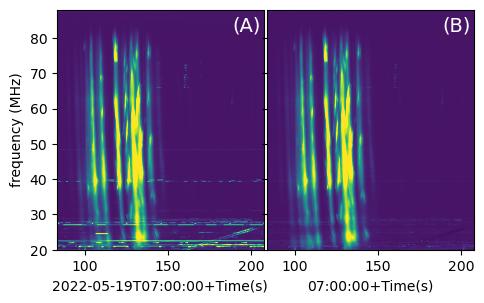

time: 453 ms (started: 2022-07-16 02:26:02 +03:00)


In [124]:

small_arr  =  conv_down_after_flag/conv_down_weight_after_flag

bdps=[]
for frq_idx in range(small_arr.shape[1]):
    bdps.append( partition_avg(small_arr[:,frq_idx],(0.01,0.1)))
bdps = np.array(bdps)


fig=plt.figure(figsize=(7,3.),dpi=100)
#fig=plt.figure(figsize=(14,6.),dpi=100)
ax1 = fig.add_axes([0.1,0.1,0.3-0.005,0.8])
ax1.imshow(np.log10(conv_down_direct/bdps[None:,]).T,
    interpolation=None,aspect='auto',origin='lower',vmax=0.9,vmin=-0.05,
    extent=[(t_idx0+t0_idx)*total_t/data_shape[0],(t_duration_idx+t0_idx)*total_t/data_shape[0],
    freq[0],freq[-1]])
plt.setp(ax1, xlabel=f['/'].attrs['OBSERVATION_START_UTC'][0:19]+'+Time(s)', ylabel='frequency (MHz)')
# text on upper left corner
ax1.text(0.85, 0.91, '(A)',color='w', transform=ax1.transAxes, fontsize=14)


texthub = ['(B)','(C)','(D)']
for idxtmp in range(1):
    ax2 = fig.add_axes([0.4+0.3*idxtmp,0.1,0.3-0.005,0.8])
    ax2.imshow(np.log10(small_arr/bdps[None,:]).T,
        interpolation=None,aspect='auto',origin='lower',vmax=0.9,vmin=-0.05,
        extent=[(t_idx0+t0_idx)*total_t/data_shape[0],(t_duration_idx+t0_idx)*total_t/data_shape[0],
        freq[0],freq[-1]])
    plt.setp(ax2, xlabel=f['/'].attrs['OBSERVATION_START_UTC'][11:19]+'+Time(s)',yticklabels=[])
    
    ax2.text(0.85, 0.91, texthub[idxtmp], color='w', transform=ax2.transAxes, fontsize=14)
    
ax1.set_ylim([20,88])
ax2.set_ylim([20,88])

fig.savefig(work_dir+'/RFIconvTypeIII.pdf',bbox_inches='tight')

#plt.imshow(np.log10(conv_down_direct/bdps[None:,]).T,interpolation=None,aspect='auto',origin='lower',
#vmax=0.4,vmin=-0.01)
#plt.ylim(1300,1800)




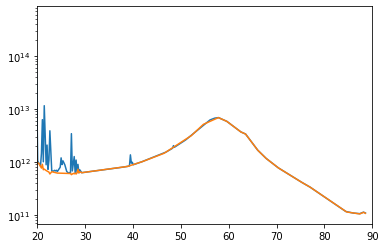

time: 390 ms (started: 2022-07-16 02:24:44 +03:00)


In [121]:

plt.plot(np.linspace(freq[0],freq[-1],small_arr.shape[1]), np.mean(conv_down_direct[-90:,:],0))
plt.plot(np.linspace(freq[0],freq[-1],small_arr.shape[1]), np.mean(small_arr[-90:,:],0))
plt.xlim([20,90])
plt.yscale('log')

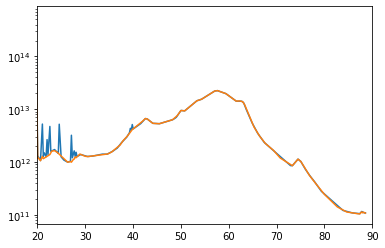

time: 421 ms (started: 2022-07-16 02:23:53 +03:00)


In [120]:

plt.plot(np.linspace(freq[0],freq[-1],small_arr.shape[1]), np.mean(conv_down_direct[40:130,:],0))
plt.plot(np.linspace(freq[0],freq[-1],small_arr.shape[1]), np.mean(small_arr[40:130,:],0))
plt.xlim([20,90])
plt.yscale('log')

In [267]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  

12
torch.Size([1, 1, 3, 3])
time: 1.26 s (started: 2022-07-07 11:31:01 +03:00)


In [268]:
from tqdm import tqdm

"""

    data_test_ma = np.ma.masked_where((output.squeeze()),data_test.squeeze())
    for shift in (-1,1):
        for axis in (0,1):        
            a_shifted=np.roll(data_test_ma,shift=shift,axis=axis)
            idx=~a_shifted.mask * data_test_ma.mask
            data_test_ma[idx]=a_shifted[idx]
"""

'\n\n    data_test_ma = np.ma.masked_where((output.squeeze()),data_test.squeeze())\n    for shift in (-1,1):\n        for axis in (0,1):        \n            a_shifted=np.roll(data_test_ma,shift=shift,axis=axis)\n            idx=~a_shifted.mask * data_test_ma.mask\n            data_test_ma[idx]=a_shifted[idx]\n'

time: 15 ms (started: 2022-07-07 11:31:09 +03:00)


In [320]:
freq_window=16
time_window=192

chunk_len = 96*60*10
big_arr = []


net = init_RFIconv(net,aggressive_factor = [1.6,1.8,0.5,0.5])

for num_chunk in tqdm(range(int((data_shape[0]-96*60*100)/chunk_len))):
    data_test=f['SUB_ARRAY_POINTING_'+SAP+'/BEAM_'+beam_this+'/STOKES_0'][
        chunk_len*num_chunk:chunk_len*(num_chunk+1),:]
    
    # no grad:
    with torch.no_grad():
        output = net(torch.tensor(data_test[None,None,:,:])).squeeze().numpy()

        conv_down_after_flag =  F.conv2d(torch.tensor(data_test[None,None,:,:]*(~output[None,None,:,:])),
                torch.ones([1,1,time_window,freq_window])/freq_window/time_window,
                stride=(time_window,freq_window),padding=(0,0)).squeeze().numpy()


        conv_down_weight_after_flag =  F.conv2d(torch.tensor(1-output[None,None,:,:])*1.0,
                torch.ones([1,1,time_window,freq_window])/freq_window/time_window,
                stride=(time_window,freq_window),padding=(0,0)).squeeze().numpy()


        small_arr  =  conv_down_after_flag/conv_down_weight_after_flag
                        

    big_arr.append(small_arr)

100%|██████████| 36/36 [05:10<00:00,  8.62s/it]

time: 5min 10s (started: 2022-07-07 13:01:54 +03:00)


In [321]:
big_arr_plot = np.concatenate(big_arr,axis=0)


time: 122 ms (started: 2022-07-07 13:07:55 +03:00)


time: 14.8 ms (started: 2022-07-07 13:07:56 +03:00)


Text(0.5, 0, 'Time (minute) from 2022-05-19T07:00:00.000000000Z')

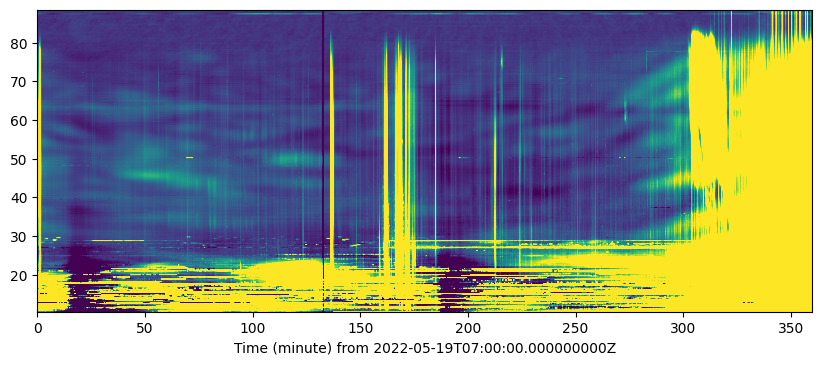

time: 678 ms (started: 2022-07-07 13:07:57 +03:00)


In [323]:
time_minute = np.arange(big_arr_plot.shape[0])*2/60

bdps=[]
for frq_idx in range(big_arr_plot.shape[1]):
    bdps.append( partition_avg(big_arr_plot[:,frq_idx],(0.15,0.2)))

bdps = np.array(bdps)

big_arr_plot_final = big_arr_plot/bdps
plt.figure(figsize=(10,4),dpi=100)
plt.imshow(np.log10(big_arr_plot_final).T,interpolation=None,aspect='auto',origin='lower',vmax=0.09,vmin=-0.015,
    extent=[time_minute[0],time_minute[-1],freq[0],freq[-1]])

plt.xlabel('Time (minute) from '+f['/'].attrs['OBSERVATION_START_UTC'])

(5500000000000.0, 7000000000000.0)

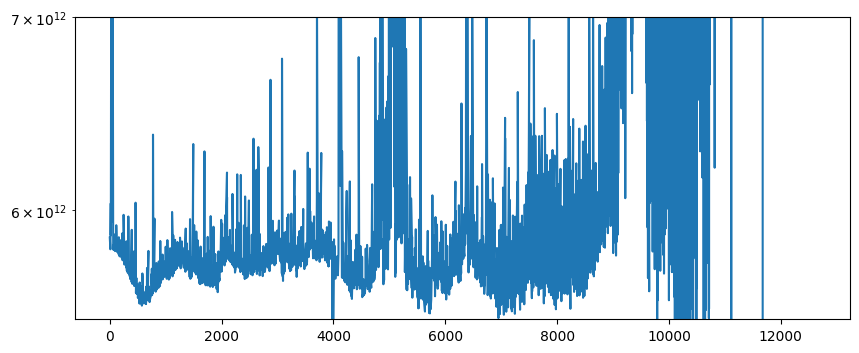

time: 174 ms (started: 2022-07-07 13:01:42 +03:00)


In [318]:

plt.figure(figsize=(10,4),dpi=100)
plt.plot((big_arr_plot[:,251]))
plt.yscale('log')
plt.ylim([5.5e12,7e12])

Text(0.5, 0, 'Time (minute) from 2022-05-19T07:00:00.000000000Z')

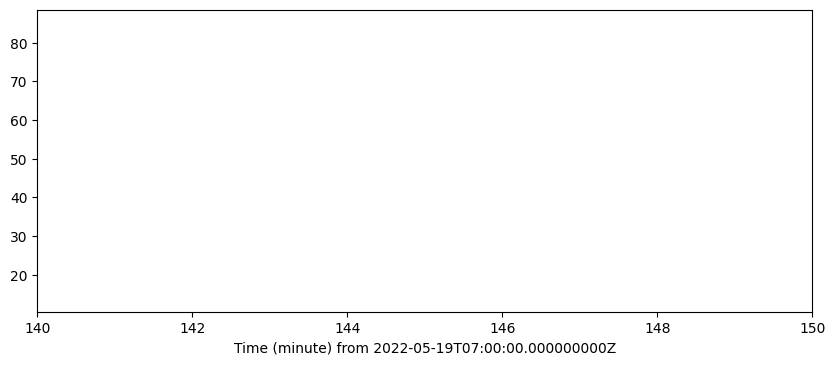

time: 94.9 ms (started: 2022-07-07 12:50:35 +03:00)


In [309]:

plt.figure(figsize=(10,4),dpi=100)
plt.imshow(np.log10(big_arr_plot_final).T,interpolation=None,aspect='auto',origin='lower',vmax=0.05,vmin=-0.015,
    extent=[time_minute[0],time_minute[-1],freq[0],freq[-1]])
plt.xlim([140,150])

plt.xlabel('Time (minute) from '+f['/'].attrs['OBSERVATION_START_UTC'])

time: 398 µs (started: 2022-07-06 00:28:01 +03:00)


In [23]:
x = torch.tensor([[1,2], [3,4], [5,6]])

time: 188 ms (started: 2022-07-16 01:43:55 +03:00)


In [33]:
x.tile(2).shape

torch.Size([3, 4])

time: 188 ms (started: 2022-07-16 01:45:28 +03:00)
